# Past Performance Analysis

This notebook looks at the past performance in the last 180 days, on a daily basis. Each of those days, looking at the delta in 30, 60, 90, 120, 150, 180 days.

Note: This notebook assumes that you have loaded data within the `data/portfolios.json` and `data/pricing` by running the `init.py`.

In [1]:
import pandas as pd
import json
from datetime import datetime, timedelta
from typing import List
import numpy as np
import os

In [2]:
# Constants
DATA_PATH = "data/pricing"
FUNDS_PATH = "data/portfolios.json"

# Limits.
DAYS_ANALYSIS_LIMIT = 180
TARGET_DAYS = [30, 60, 90, 120, 150, 180]

# Columns.
COLUMN_DATE = "asOfDate"

## Initial Load

Loads all the data necessary to access funds.

In [3]:
# Get all the funds from the file.
with open(FUNDS_PATH, "r") as f:
    funds = json.load(f)

# Convert to ID to fund.
funds_map = {f["portId"]: f for f in funds}

print(funds_map)

{'8617': {'allocation': 'Bonds 0%,Cash 0%,Shares 100%', 'annualReturns': [{'value': '+18.95%', 'label': '01 Oct 2023 - 30 Sep 2024'}, {'value': '+9.96%', 'label': '01 Oct 2022 - 30 Sep 2023'}, {'value': '-4.65%', 'label': '01 Oct 2021 - 30 Sep 2022'}, {'value': '+23.09%', 'label': '01 Oct 2020 - 30 Sep 2021'}, {'value': '+4.38%', 'label': '01 Oct 2019 - 30 Sep 2020'}], 'annualReturnData': {}, 'assetClass': 'equity', 'domicileType': 'gb-domicile', 'esgType': '', 'fundCategory': 'buildMyOwn', 'id': 'vanguard-ftse-global-all-cap-index-fund-gbp-acc', 'ids': {}, 'inceptionDate': '2016-11-08', 'inceptionDates': {}, 'managementType': 'Index', 'name': 'FTSE Global All Cap Index Fund', 'noaValue': '7516', 'ocfValue': 0.23, 'ocfValues': {}, 'portId': '8617', 'parentPortId': '8617', 'productType': 'mf', 'readyMadeType': '', 'regionType': 'Global', 'riskLevel': '5', 'shareClass': 'Accumulation', 'sedol': 'BD3RZ58', 'fundGroupHedgedFunds': False, 'closeIndicator': False, 'upcomingChanges': False}, 

## Computing Performance

This section computes all the performance on a daily basis, for all the funds.

In [4]:
def compute_day_performance(
    df: pd.DataFrame,
    date: datetime,
    days: int,
    formatted_min_date: str,
    formatted_date: str,
) -> float:
    # Determine if the date is within the index.
    # Need to account for potential missing data due to weekends.
    target = date - timedelta(days=days)
    formatted_target = target.strftime("%Y-%m-%d")

    # If we are asking for something outside of index, just NAN.
    if formatted_target < formatted_min_date:
        return np.nan

    # If the target is within range but not present, then probably is a weekend.
    while formatted_target not in df.index:
        # Try to find another price.
        target -= timedelta(days=1)
        formatted_target = target.strftime("%Y-%m-%d")

    # Get the prices.
    end_price = df.loc[formatted_date]["price"]
    start_price = df.loc[formatted_target]["price"]

    # Compute the percentual gain.
    return 100 * ((end_price / start_price) - 1)


def compute_performance(
    df: pd.DataFrame,
    target_days: List[int] = TARGET_DAYS,
    days_limit: int = DAYS_ANALYSIS_LIMIT,
) -> pd.DataFrame:
    # Reindex.
    df_date = df.set_index(COLUMN_DATE)

    # Prepare the dates we are going to iterate.
    min_date = min(df_date.index)
    last_date = datetime.strptime(max(df_date.index), "%Y-%m-%d").date()
    first_date = last_date - timedelta(days=days_limit)

    # Results will be stored here.
    result_df = pd.DataFrame(columns=target_days)

    # Iterate all the days we need to process.
    for d in pd.date_range(start=first_date, end=last_date):
        date = d.date()
        formatted_date = date.strftime("%Y-%m-%d")

        # The fund data doesn't go that far back.
        if formatted_date not in df_date.index:
            continue

        # Write back in the dataframe in the index.
        result_df.loc[formatted_date] = {
            day: compute_day_performance(
                df=df_date,
                date=date,
                days=day,
                formatted_date=formatted_date,
                formatted_min_date=min_date,
            )
            for day in target_days
        }

    return result_df

In [5]:
# Holds all the funds by ID and
funds_performance = {
    fid: compute_performance(df=pd.read_csv(os.path.join(DATA_PATH, f"{fid}.csv")), days_limit=180)
    for fid in funds_map
}

In [26]:
# Plotting Every chart by date.
day_based_stats = {
    day: pd.concat(
        [
            funds_performance[fund["portId"]][day].rename(
                f"{fund['name']} ({fund['shareClass']})"
            )
            for fund in funds
        ],
        axis=1,
    )
    for day in TARGET_DAYS
}

Number of acceptable funds: (130, 29) (30-day Performance)
Number of acceptable funds: (130, 42) (60-day Performance)
Number of acceptable funds: (130, 22) (90-day Performance)
Number of acceptable funds: (130, 19) (120-day Performance)
Number of acceptable funds: (130, 71) (150-day Performance)
Number of acceptable funds: (130, 49) (180-day Performance)


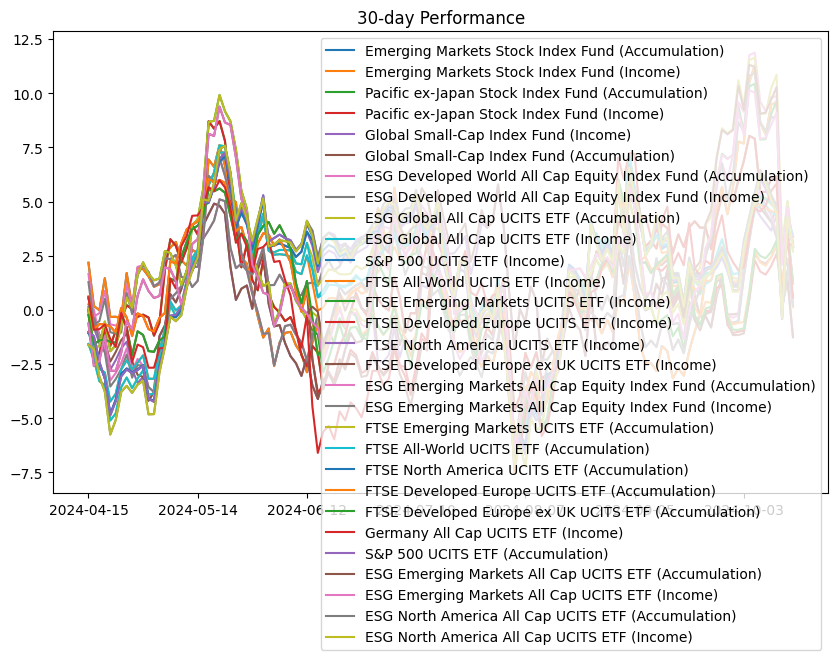

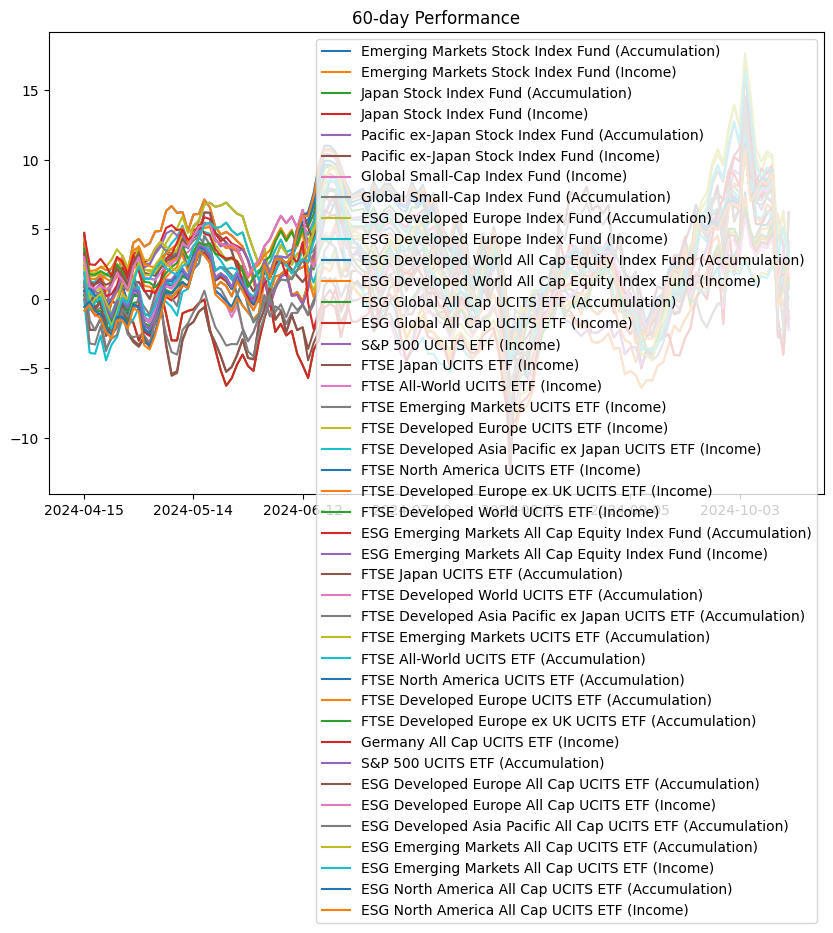

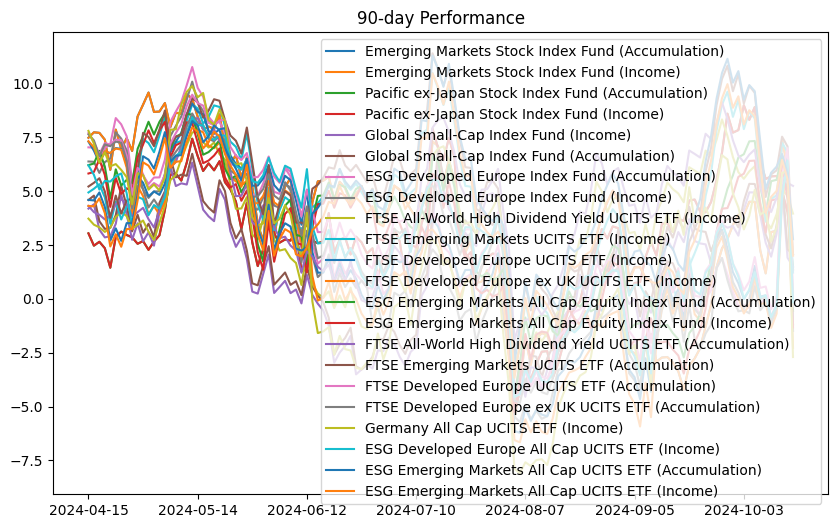

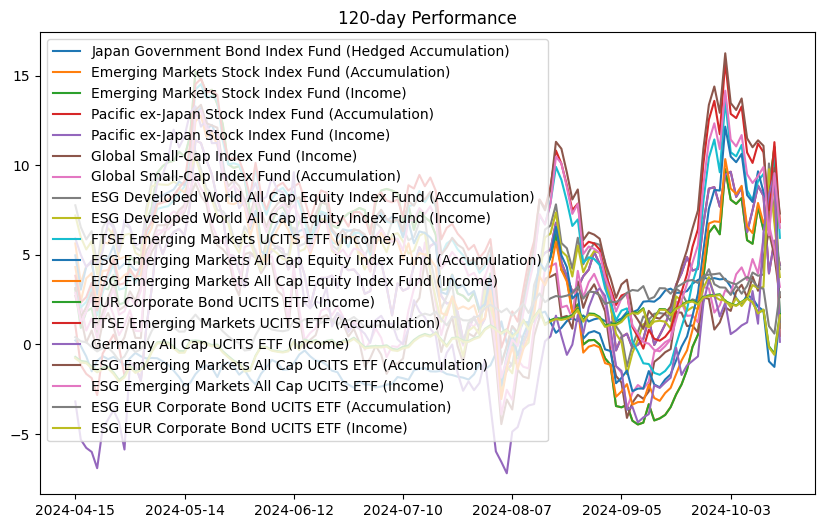

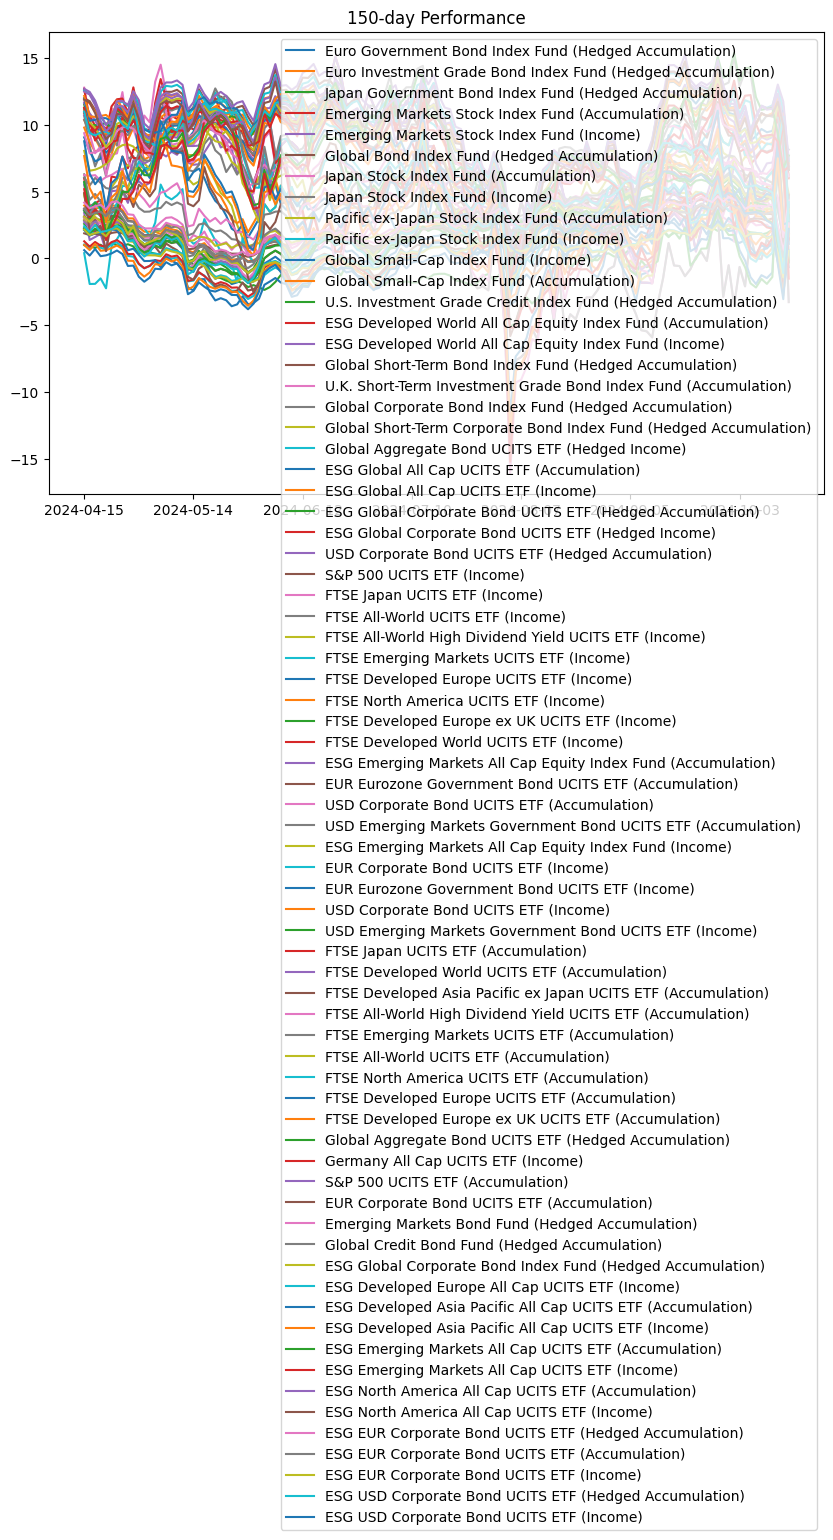

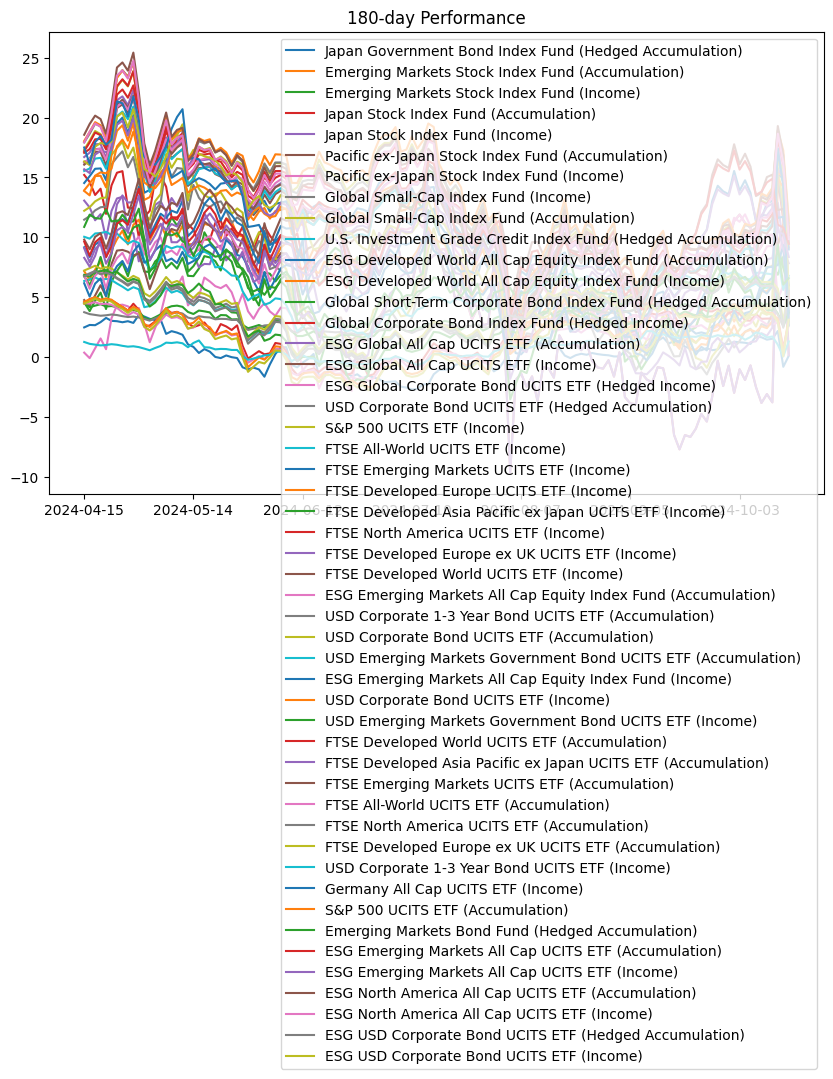

In [27]:
# Handles negative performance.
remove_negative_performance = False
negative_percentual_threshold = 0.2

# Handles regular performance.
remove_regular_performance = False
regular_percentual_threshold_year = 5.5

# Handles potential buys because they are cheap.
show_only_potential_buys = False
potential_buy_day_threshold = 10

# Do all the plots.
for day in day_based_stats:
    df_to_plot = day_based_stats[day]

    # Determines if removes the ones that have more than a certain percentage of negative returns.
    if remove_negative_performance:
        df_to_plot = df_to_plot.loc[
            :, (df_to_plot < 0).mean() <= negative_percentual_threshold
        ]

    # Determines if removes the ones that have more than a certain percentage of negative returns.
    if remove_regular_performance:
        df_to_plot = df_to_plot.loc[
            :, df_to_plot.mean() >= regular_percentual_threshold_year * (day / 365)
        ]

    # Handles no values to plot.
    if not df_to_plot.empty and len(df_to_plot.shape) > 1:
        print(
            f"Number of acceptable funds: {df_to_plot.shape} ({day}-day Performance)"
        )
        df_to_plot.plot(figsize=(10, 6), title=f"{day}-day Performance")

In [ ]:
# Shows only potential buys according to rolling window.
    if show_only_potential_buys:
        rolling_avg = df_to_plot.shift(1).rolling(
            window=potential_buy_day_threshold
        ).mean()
        df_to_plot = df_to_plot.loc[:, (rolling_avg > df_to_plot).iloc[-1]]